In [109]:
try:
    import ribs
except Exception as e:
    print(e)
    %pip install ribs[visualize]

import time
import sys
import numpy as np
from tqdm import trange

In [110]:
from qdglue.tasks.knights_tour import KnightsTour

In [111]:
knights_tour = KnightsTour("hand")

In [112]:
# initialize a new population

In [162]:
total_itrs = 10_000
batch_size = 1024

In [163]:
from ribs.archives import GridArchive

archive = GridArchive(
    solution_dim=66,
    dims=[8, 8],
    threshold_min=-np.inf,
    ranges=[(0, 8)] * 2)

In [164]:
from ribs.emitters import GaussianEmitter

emitters = [
    GaussianEmitter(
        archive=archive,
        sigma=0.3,
        x0=np.array([4.0 for i in range(66)]),
        bounds=[(0.0, 7.99)] * 66,
        batch_size=batch_size//4,
    ) for _ in range(4)
]

In [165]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters)

In [166]:
metrics = {
    "Archive Size": {
        "itrs": [0],
        "vals": [0],  # Starts at 0.
    },
    "Max Objective": {
        "itrs": [],
        "vals": [],  # Does not start at 0.
    },
}

for itr in trange(1, total_itrs + 1, desc='Iterations', file=sys.stdout):
    sols = scheduler.ask()
    objs, _, feats, _ = knights_tour.evaluate(np.floor(sols).astype(int))
    scheduler.tell(objs, feats)

    # Logging.
    if itr % 50 == 0:
        metrics["Archive Size"]["itrs"].append(itr)
        metrics["Archive Size"]["vals"].append(len(archive))
        metrics["Max Objective"]["itrs"].append(itr)
        metrics["Max Objective"]["vals"].append(archive.stats.obj_max)

Iterations: 100%|██████████████████| 10000/10000 [04:39<00:00, 35.80it/s]


Final Archive Size: 64
Final Max Objective: 37


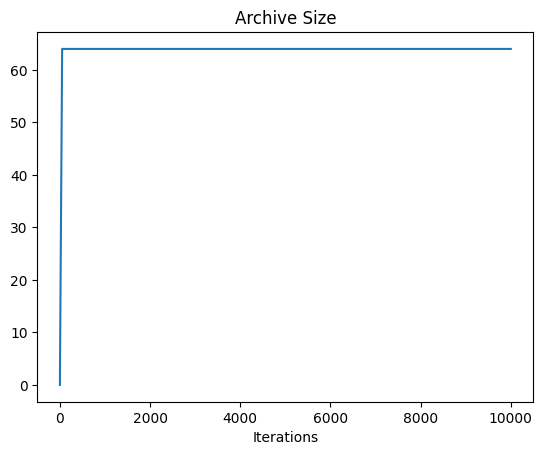

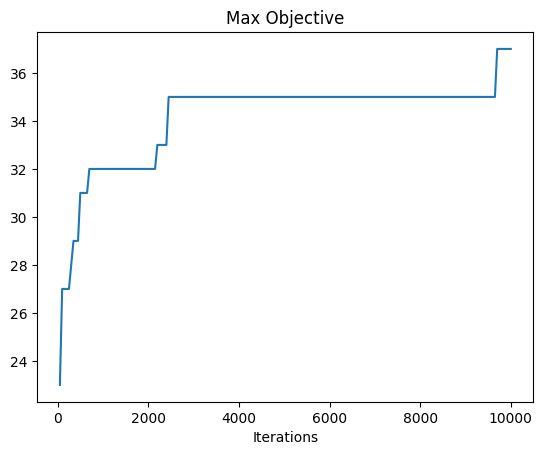

In [167]:
import matplotlib.pyplot as plt

for metric in metrics:
    plt.figure()
    plt.plot(metrics[metric]["itrs"], metrics[metric]["vals"])
    plt.title(metric)
    plt.xlabel("Iterations")
    print(f"Final {metric}: {metrics[metric]['vals'][-1]}")

Text(0.5, 1.0, 'Final Positions of a 12-DoF Arm')

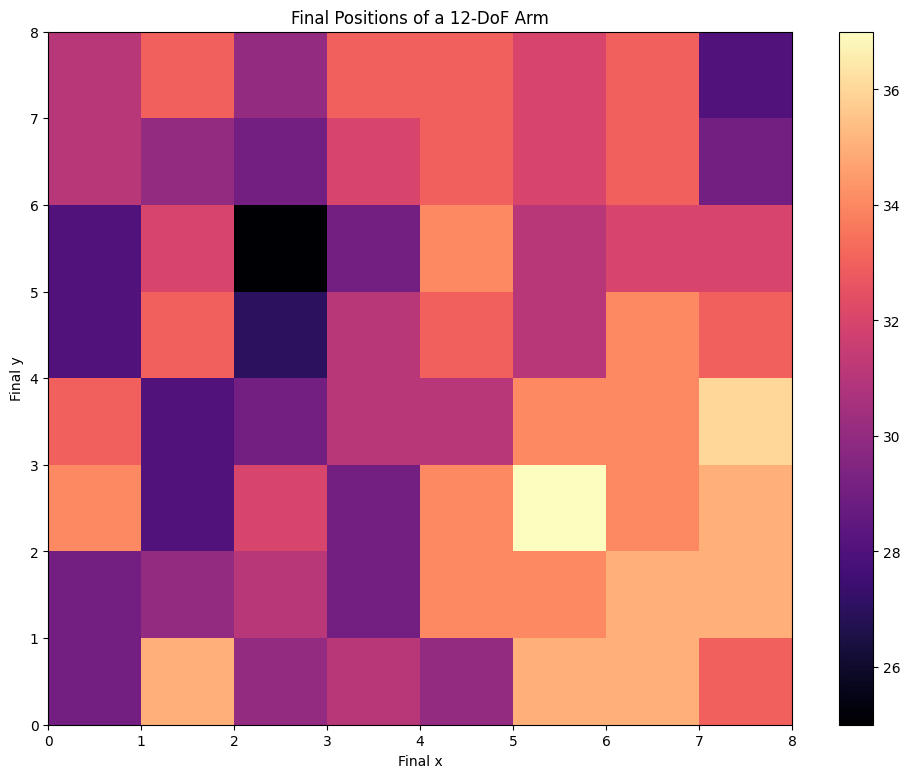

In [168]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(12, 9))
grid_archive_heatmap(archive)
plt.xlabel("Final x")
plt.ylabel("Final y")
plt.title("Final Positions of a 12-DoF Arm")